In [1]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [2]:
#|export
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import os,glob

#from dementia_inequalities.tools.health_helpers import polygon_area 

In [3]:
N_intersections = 100

## Load files 

In [4]:
# Load geojson files of LAD boundaries
gdf_LAD = gpd.read_file(const.data_path+'/LAD_area/LAD_Dec_2021_GB_BFC_2022_-8975151699474964544.geojson')

# Remove Wales :( 
gdf_LAD = gdf_LAD.drop(gdf_LAD[gdf_LAD['LAD21CD'].str.startswith('W')].index)


In [5]:
# Load geojson files of GP catchment areas 
gdf_catchment = gpd.read_file(const.data_path+'/Catchment Area/A81001.geojson')
for filename in glob.glob(os.path.join(const.data_path+'/Catchment Area/', '*.geojson')):
  gdf_catchment = pd.concat([gdf_catchment, gpd.read_file(filename)])

gdf_catchment.rename(columns={'name': 'Name'}, inplace=True)
# get rid of those whose surgeries are un-named
gdf_catchment = gdf_catchment[gdf_catchment['Name'].notna()]

# tidy gp catchment area dataframe 
gdf_catchment.reset_index(inplace=True)

In [6]:
# Population of LADs
population_data_path = const.output_path + '/LAD_age_2021.csv'
df_pop = pd.read_csv(population_data_path)
df_pop = df_pop[['LAD_name', 'all_age']]

# Add population
gdf_LAD = gdf_LAD.merge(df_pop, left_on='LAD21NM', right_on='LAD_name')

In [7]:
# Change the crs 
gdf_catchment = gdf_catchment.to_crs(epsg=3857)
gdf_LAD = gdf_LAD.to_crs(epsg=3857)

## Remove the worst data entry errors in the GP catchment areas 

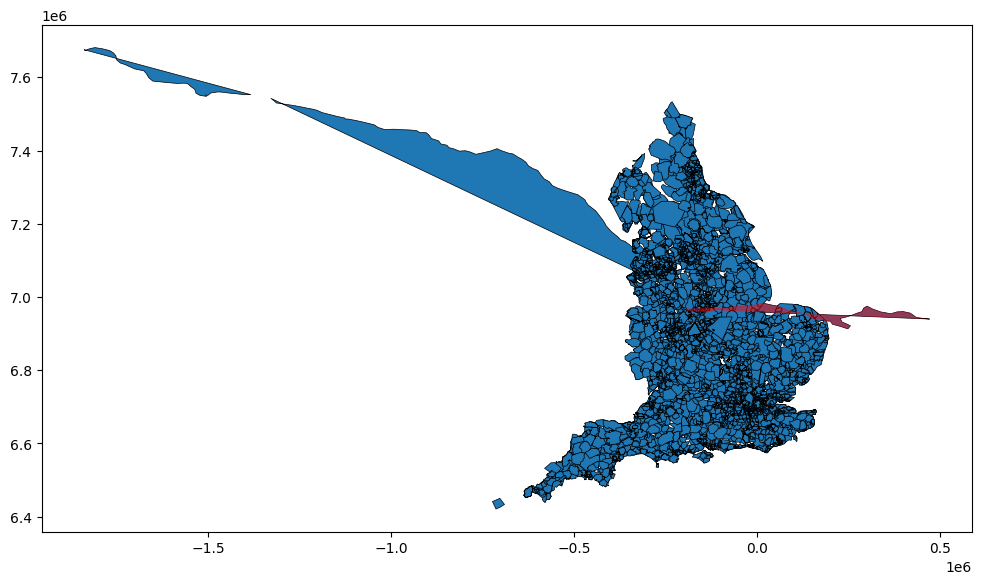

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
gdf_catchment.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=1.0)
gdf_catchment.loc[[948],'geometry'].plot(ax=ax, color='red', alpha=0.5)
plt.show()

In [9]:
gdf_catchment['area'] = gdf_catchment.area / 1000000
areas = gdf_catchment['area']
areas_with_index = []
for i in range(len(gdf_catchment['geometry'])):
    #area = polygon_area(gdf_catchment['geometry'][i])
    #areas.append(gdf_catchment['area'])
    #areas.append(area)
    areas_with_index.append( (i, areas[i]) )
areas_with_index.sort(key=lambda d: d[1])

gdf_catchment['area'] = areas

In [10]:
for i, area in areas_with_index[-10:]:
    name = gdf_catchment.iloc[i].Name
    print('(%s) %s: %se9' % (i, name, np.round(area/1e9,2)))

(5846) L83038002 - LIFTON SURGERY: 0.0e9
(1945) A84032 - CHEVIOT MEDICAL GROUP: 0.0e9
(7978) A84027 - BELLINGHAM PRACTICE: 0.0e9
(272) C83056 - EAST LINDSEY MEDICAL GROUP: 0.0e9
(365) Y02639 - SPRING HOUSE HEALTH: 0.0e9
(948) LANCELOT MEDICAL CENTRE: 0.0e9
(8606) B82045 - CENTRAL DALES PRACTICE: 0.0e9
(947) LANCELOT MEDICAL CENTRE: 0.0e9
(7138) AEGIS MEDICAL CENTRE: 0.0e9
(946) LANCELOT MEDICAL CENTRE: 0.0e9


In [11]:
# All of these catchment areas need to removed 
gdf_catchment[gdf_catchment['Name'].str.contains("LANCELOT MEDICAL CENTRE")]

,index,stroke-opacity,Name,Region,SubICBCode,ICBCode,ODSCode,fill-opacity,stroke,OrgLongitude,OrgLatitude,geometry,DCORegion,CCGCode,area
946,0,1.0,LANCELOT MEDICAL CENTRE,NaN,NaN,NaN,E84063,0.0,#0000FF,NaN,NaN,"POLYGON ((-114376.658 6965691.189, -125582.635...",NaN,NaN,88670.714667
947,1,1.0,LANCELOT MEDICAL CENTRE,NaN,NaN,NaN,E84063,0.0,#0000FF,NaN,NaN,"POLYGON ((-1383669.433 7552858.586, -1396446.3...",NaN,NaN,6216.338887
948,2,1.0,LANCELOT MEDICAL CENTRE,NaN,NaN,NaN,E84063,0.0,#0000FF,NaN,NaN,"POLYGON ((-114503.896 6963909.706, -120191.877...",NaN,NaN,4634.058426


<Axes: >

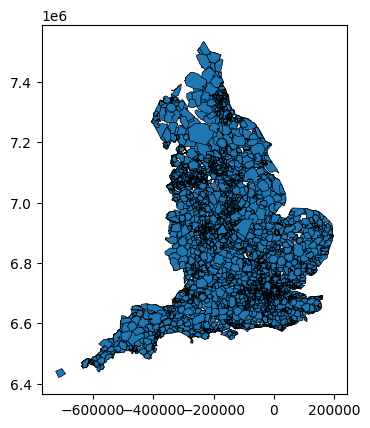

In [12]:
# Drop the worst areas 
gdf_catchment = gdf_catchment.drop([948, 947, 946, 7138])
# reset the index 
gdf_catchment.reset_index(inplace=True)
gdf_catchment.drop(columns=['level_0', 'index'], inplace=True)

# and re-plot
gdf_catchment.plot(edgecolor='black', linewidth=0.5)

**Note to Bea** That GP catchment area off the end of cornwall is fine - you forgot the Isles of Scilly silly... 

## Option to merge with QOF

In [13]:
# # Merge with QOF data to ensure that we don't use GPs that have no QOF data
# unmerged_gdf_catchment = gdf_catchment
# gdf_catchment = unmerged_gdf_catchment.merge(df_QOF, left_on='ODSCode', right_on='pcode')

## Intersections
Compute intersections $A_{ik}$ between LADs $i$ and GP $k$ catchment areas. 

In [14]:
###### my version ######

# Compute intersections between LADs and GP catchment areas

gdf_catchment['area'] = gdf_catchment.area / 1000000
gdf_LAD['area'] = gdf_LAD.area / 1000000

LAD_GP_catchment_area_intersections = []

GP_xs = np.array(gdf_catchment['geometry'].centroid.x)
GP_ys = np.array(gdf_catchment['geometry'].centroid.y)

for i, LAD_row in gdf_LAD.iterrows():
    
    LAD_center = LAD_row.geometry.centroid
    dx = GP_xs - LAD_center.x
    dy = GP_ys - LAD_center.y
    dists = np.sqrt(dx**2 + dy**2)
    closest_GPs = gdf_catchment.index[dists.argsort()[:N_intersections]]
    
    inters = []
    _intersection_areas = []
    for j in closest_GPs:
        inter = gdf_catchment.loc[j].geometry.buffer(0).intersection(LAD_row.geometry).area
        inter = inter / 1000000
        inters.append(inter)
        if inter != 0:
            _intersection_areas.append([j, inter])
            
    LAD_GP_catchment_area_intersections.append(_intersection_areas)
    

In [15]:
# These are the GPs whose catchment areas overlap with the first LAD [0], the first number refers to the index in the df 
LAD_GP_catchment_area_intersections[0]

[[7228, 154.810845337167],
 [1607, 168.86601043488986],
 [7219, 185.28498667506287],
 [7959, 189.60302197291617],
 [2654, 214.43615125571887],
 [4874, 205.85797876224902],
 [1918, 169.22927289128754],
 [8896, 146.9007454879629],
 [6063, 165.85291275323877],
 [8897, 1.3859965752148822],
 [8643, 181.03554560682434],
 [1608, 35.90296664994502],
 [4832, 0.1484593855575255],
 [8895, 2.050797634442627],
 [2773, 28.950216305437756],
 [3309, 28.950216305437756],
 [1128, 0.3850899095425722],
 [6054, 3.337200683999345],
 [6032, 13.276647451345358],
 [9780, 4.145825484906891],
 [266, 1.8595415224999012],
 [6540, 2.520885349039329],
 [7841, 0.908386233469951],
 [35, 9.59458639239448],
 [7227, 22.425373252558916],
 [8148, 1.8708369313054396],
 [9548, 0.46924311545821423],
 [5300, 12.275965483233433],
 [877, 2.8081094817634895],
 [6390, 12.43754106062427],
 [871, 0.7527715893098723]]

See which LADs fall outside of catchment areas

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_15487/2938436608.py:9: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gdf_LAD.loc[LADs_with_no_GPs,'geometry'].plot(ax=ax, color='red', alpha=0.5)


<Axes: >

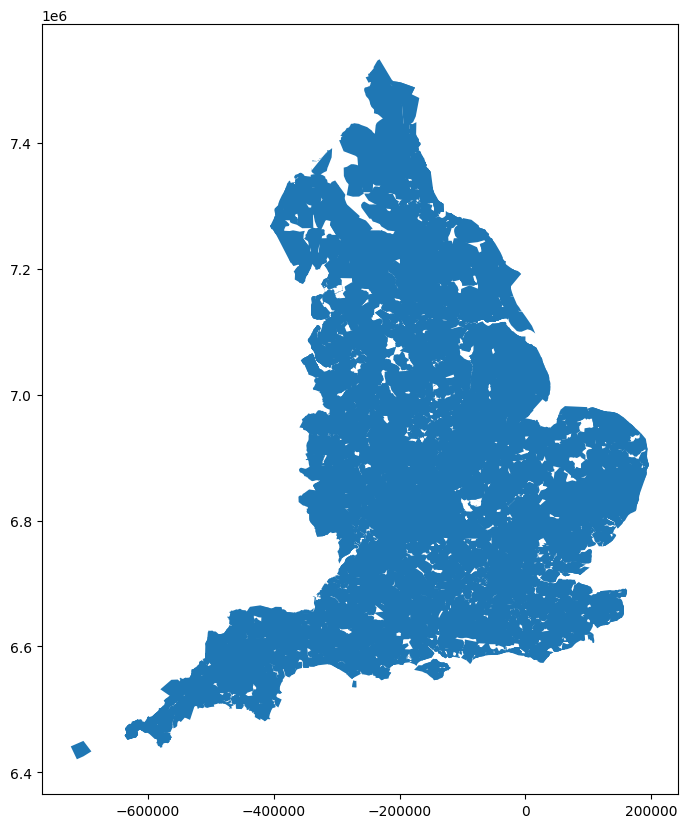

In [16]:
LADs_with_no_GPs = []
for i in range(len(LAD_GP_catchment_area_intersections)):
    if len(LAD_GP_catchment_area_intersections[i]) == 0:
        LAD_i = gdf_LAD.index[i]
        LADs_with_no_GPs.append(LAD_i)
      
fig, ax = plt.subplots(figsize=(10,10))
gdf_catchment.plot(ax=ax)
gdf_LAD.loc[LADs_with_no_GPs,'geometry'].plot(ax=ax, color='red', alpha=0.5)

## Population of the intersections 

Compute the population $I_{ik}$ of the intersection of LAD $i$ and GP $k$

In [17]:
###### my version ######

for i in range(len(gdf_LAD)):
    intersection_data = LAD_GP_catchment_area_intersections[i]
    
    for k in range(len(intersection_data)):
        gp_index = intersection_data[k][0]
        int_area = intersection_data[k][1]

        LAD_area = gdf_LAD.iloc[i].area
        int_pop = (int_area / LAD_area) * gdf_LAD.iloc[i]['all_age']
        intersection_data[k].append(int_pop)

        intersection_data[k].append(gdf_LAD['LAD_name'][i])
        intersection_data[k].append(gdf_catchment.iloc[gp_index].Name)

In [18]:
print(len(LAD_GP_catchment_area_intersections))
print(len(LAD_GP_catchment_area_intersections[0]))

309
31


## Overlapping GP catchment areas

I think it's worth noting that there is sometimes considerable overlap between gP catchment areas. This might be becuase one of the GP practices has closed down - this should become clear when the information is merged with QOF data. 

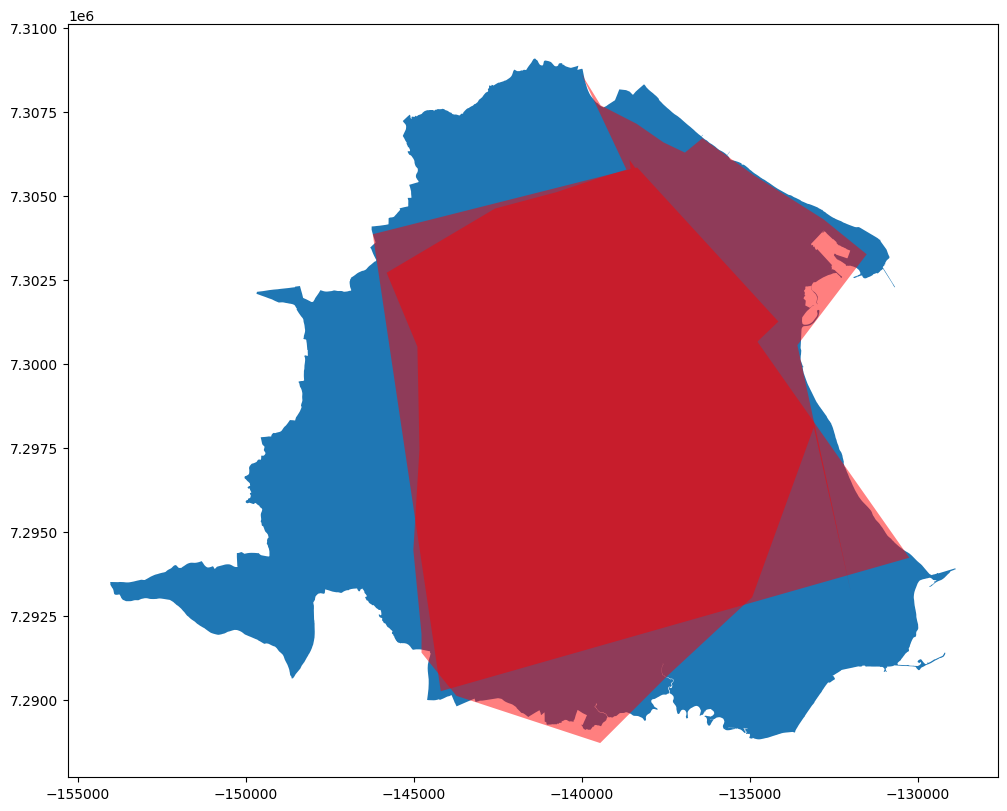

In [19]:
fig, ax = plt.subplots(figsize=(12,10))
gdf_LAD.loc[[0], 'geometry'].plot(ax=ax, linewidth=0.5, alpha=1.0)
gdf_catchment.loc[[7228], 'geometry'].plot(ax=ax, color='red', linewidth=0.5, alpha=0.5)
gdf_catchment.loc[[1607], 'geometry'].plot(ax=ax, color='red', linewidth=0.5, alpha=0.5)
#gdf_catchment.loc[[948],'geometry'].plot(ax=ax, color='red', alpha=0.5)
plt.show()

## Save data

In [20]:
LAD_GP_catchment_area_intersections = np.array(LAD_GP_catchment_area_intersections, dtype=object)

# flatten the array structure
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

In [21]:
df = pd.DataFrame(flatten_comprehension(LAD_GP_catchment_area_intersections), columns=['gp_index', 'intersection_size', 'pop', 'LAD', 'gp_name'])

df.head()

,gp_index,intersection_size,pop,LAD,gp_name
0,7228,154.810845,51241.009004,Hartlepool,A81070 - WYNYARD ROAD PRIMARY CARE CENTRE
1,1607,168.866010,55893.143290,Hartlepool,A81622 - GLADSTONE HOUSE SURGERY
2,7219,185.284987,61327.677980,Hartlepool,A81060 - THE KOH PRACTICE
3,7959,189.603022,62756.909149,Hartlepool,A81044 - MCKENZIE HOUSE SURGERY
4,2654,214.436151,70976.453448,Hartlepool,A81007 - BANKHOUSE SURGERY


In [22]:
df.to_csv(const.output_path+'/GP_LAD_intersections.csv', index=False)